# <center>Time series analysis in Python</center>

Original source: https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb#Time-series-lags

# Practical session outline:
1. [Introduction](#Introduction)
   - [Forecast quality metrics](#Forecast-quality-metrics)
2. [Move, smoothe, evaluate](#Move,-smoothe,-evaluate)
   - Rolling window estimations
   - Exponential smoothing, Holt-Winters model
   - Time-series cross validation, parameters selection
3. [Econometric approach](#Econometric-approach)
   - Stationarity, unit root
   - Getting rid of non-stationarity
   - SARIMA intuition and model building
4. [Linear (and not quite) models for time series](#Linear-(and-not-quite)-models-for-time-series)
   - [Feature extraction](#Feature-extraction)
   - [Time series lags](#Time-series-lags)
   - [Target encoding](#Target-encoding)
   - [Regularization and feature selection](#Regularization-and-feature-selection)
   - [Boosting](#Boosting)
5. [Conclusion](#Conclusion)
6. [Demo assignment](#Demo-assignment)
7. [Useful resources](#Useful-resources)

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

As an example, let's look at real mobile game data. Specifically, we will look into ads watched per hour and in-game currency spend per day.
The dataset size is well adapted to our practical session.

In [3]:
ads = pd.read_csv('data/ads.csv', index_col=['Time'], 
                  parse_dates=['Time'])
currency = pd.read_csv('data/currency.csv', index_col=['Time'], 
                       parse_dates=['Time'])

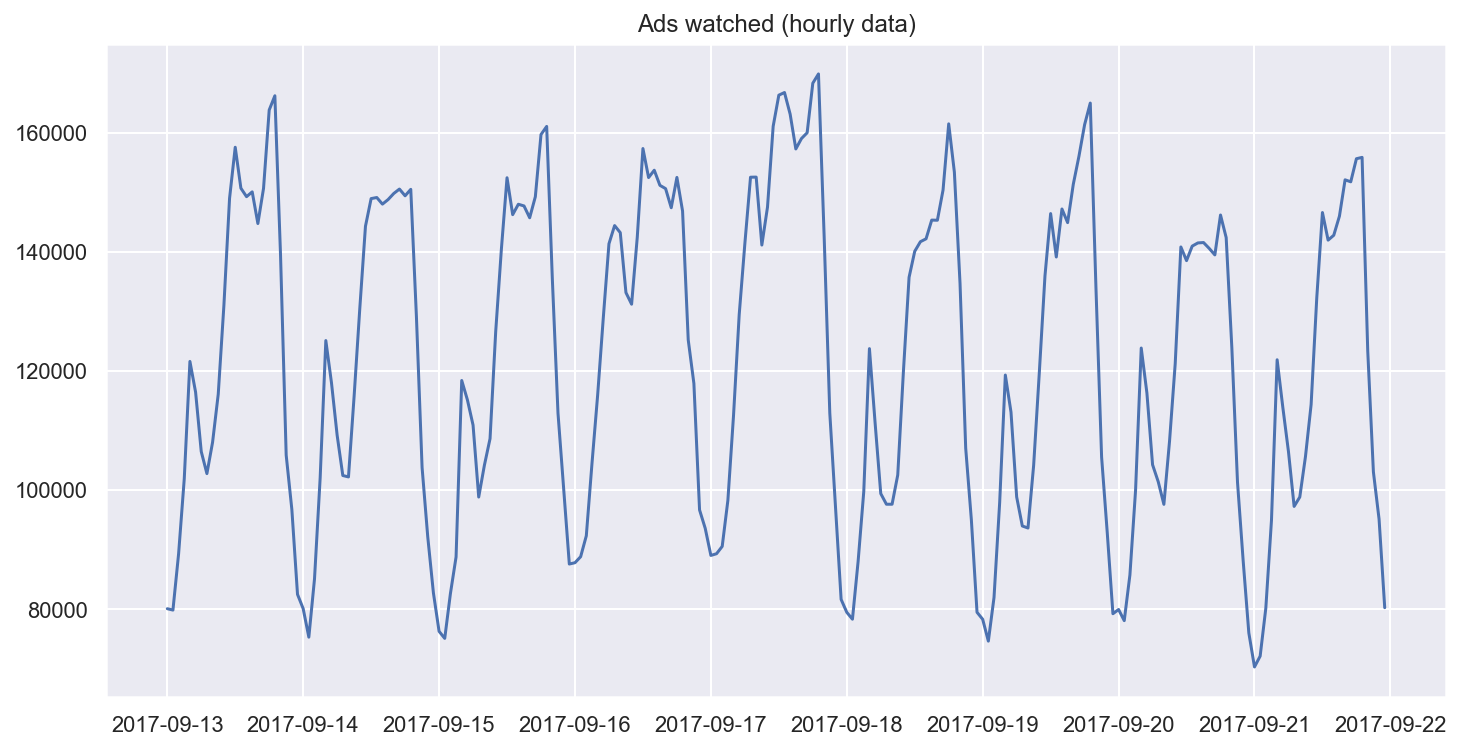

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

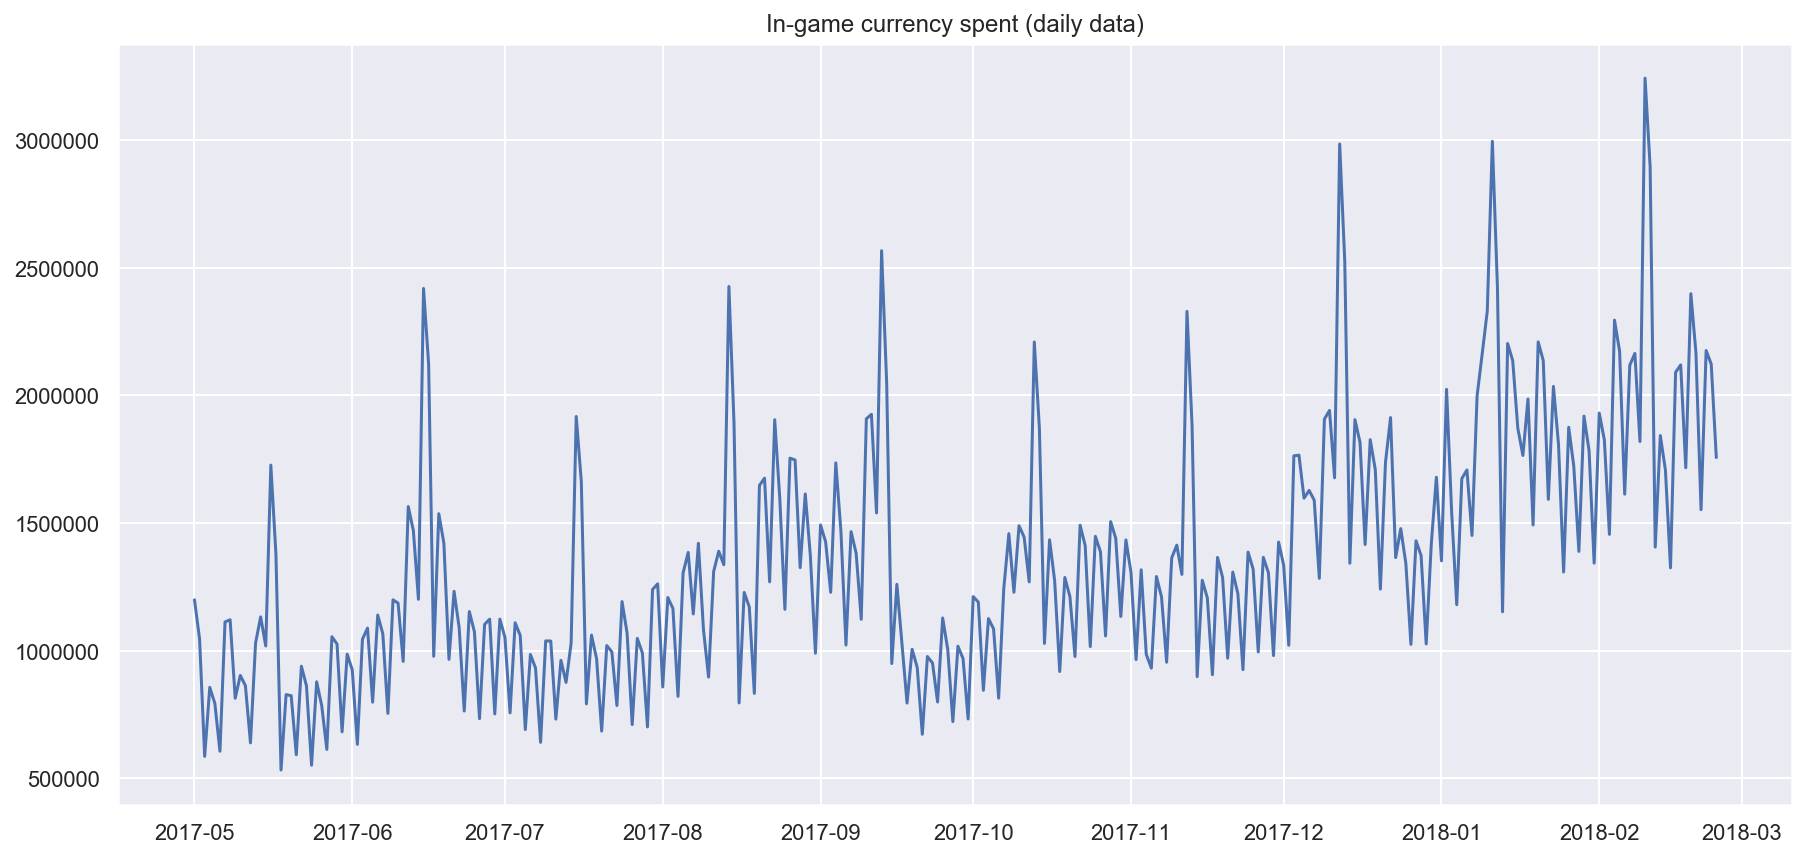

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

## A. Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [5]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Now that we know how to measure the quality of the forecasts, let's see what metrics we can use and how to translate the results for the boss. After that, one small detail remains - building the model.

# B. Move, smoothe, evaluate

First very simple prediction model

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [6]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

Unfortunately, we cannot make predictions far in the future - in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [7]:
def plotMovingAverage(series, window):

    """
        series - dataframe with timeseries
        window - rolling window size 
    """
    rolling_mean = series.rolling(window=window).mean() # compute series of successive values of window size

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Let's smooth by the previous 4 hours.

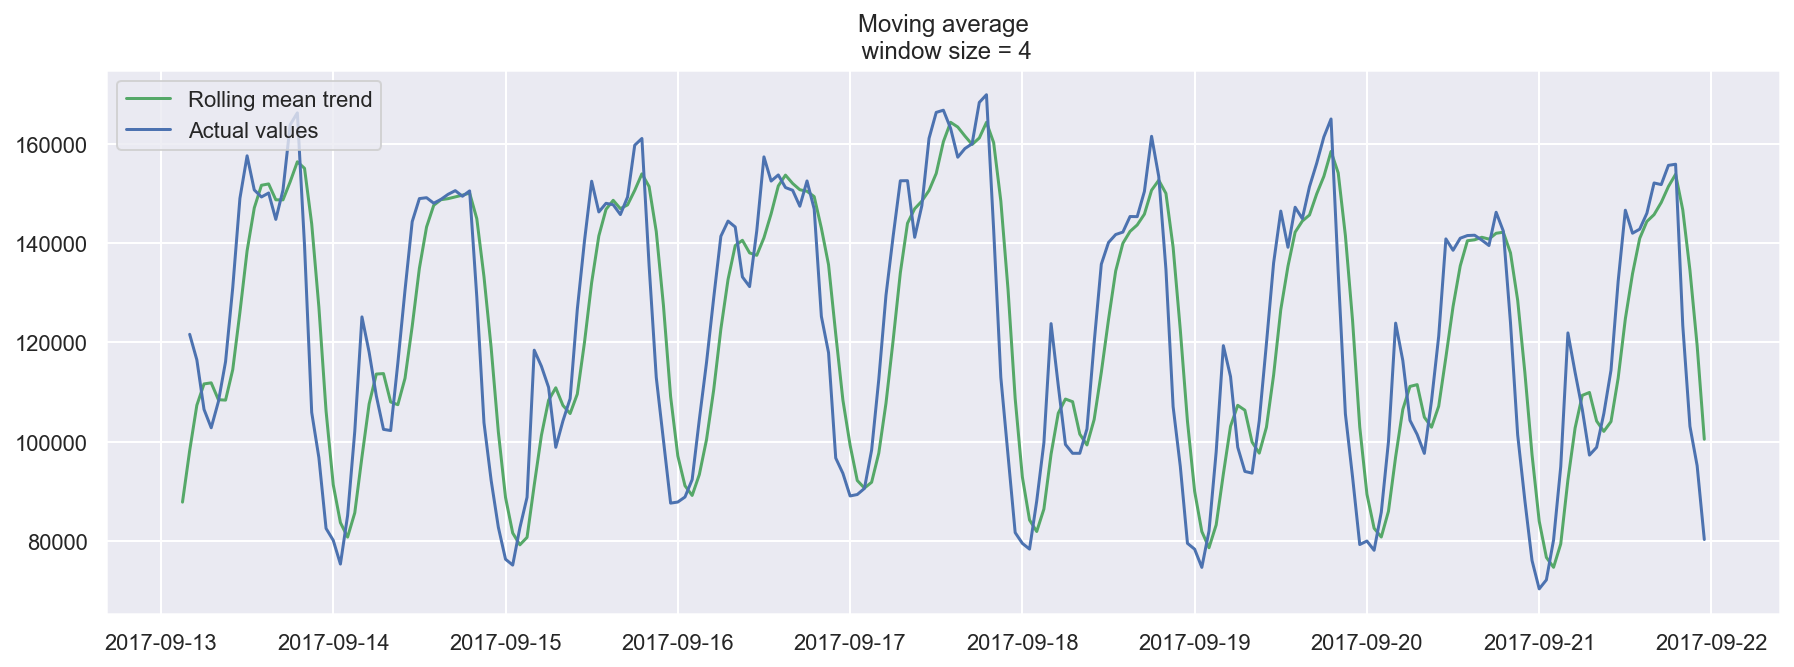

In [8]:
plotMovingAverage(ads, 4) 

Now let's try smoothing by the previous 12 hours.

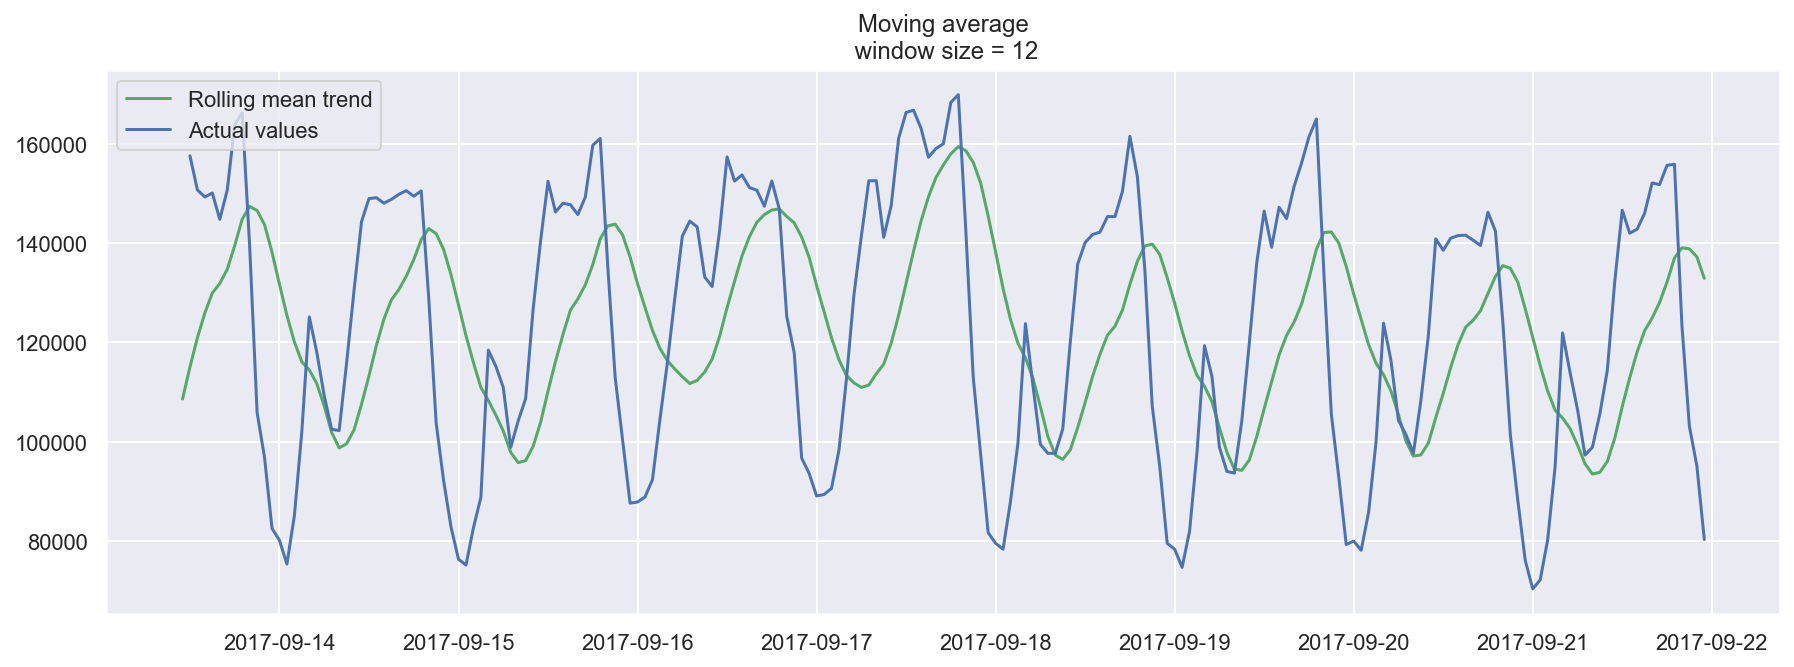

In [9]:
plotMovingAverage(ads, 12) 

## C. Exponential smoothing

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for **[exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function – we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [13]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [14]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

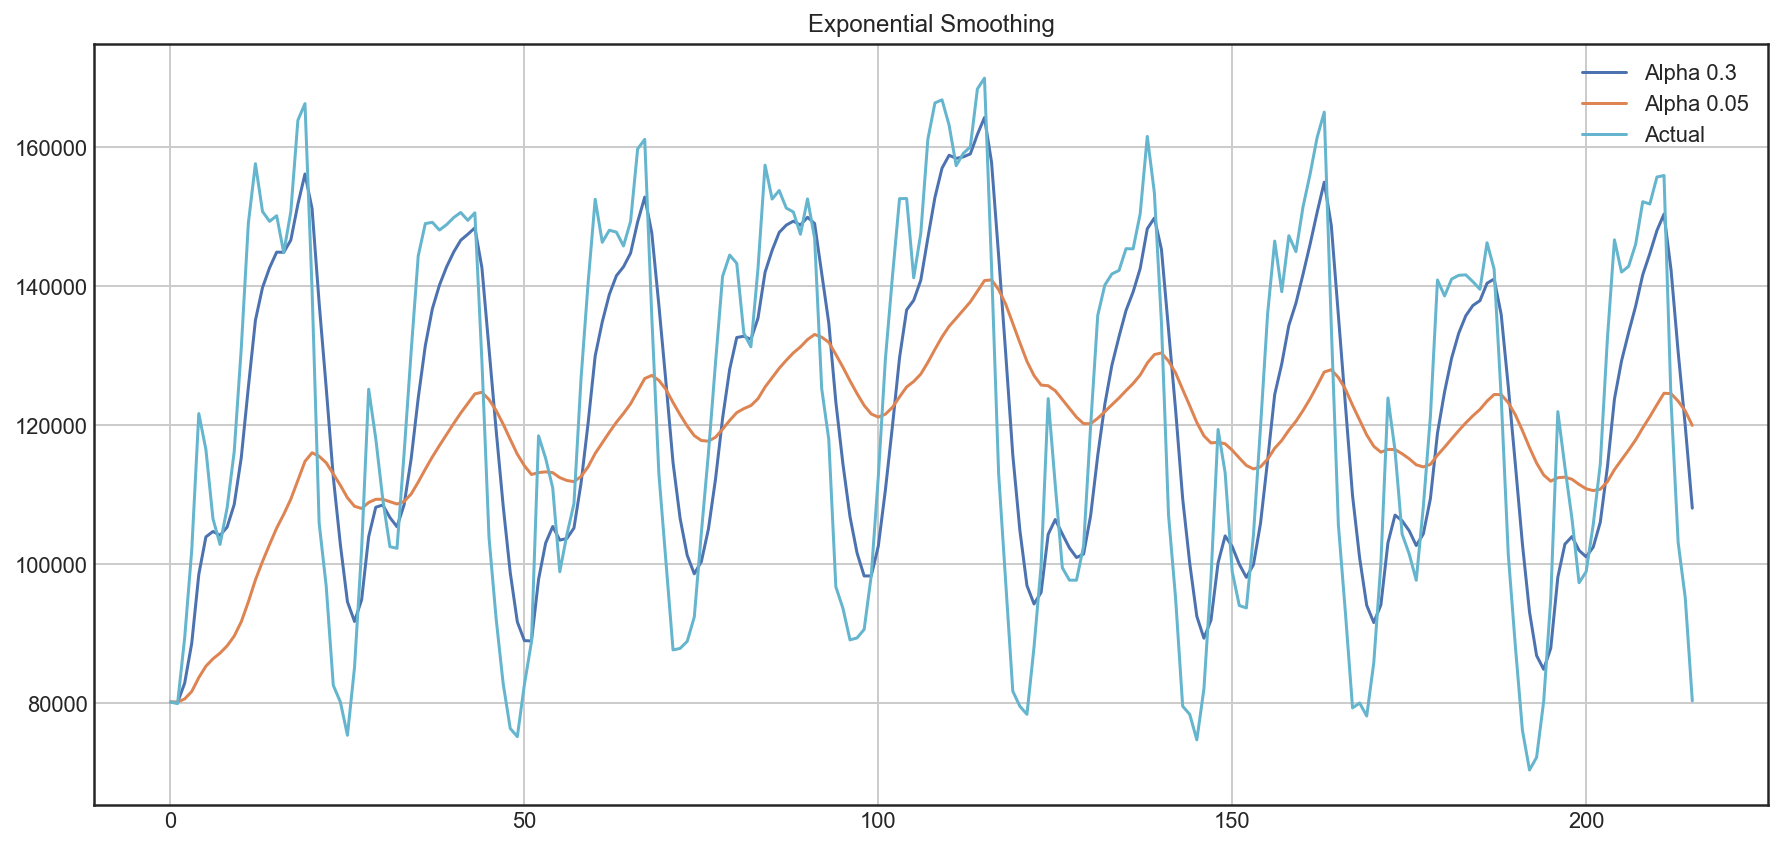

In [15]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

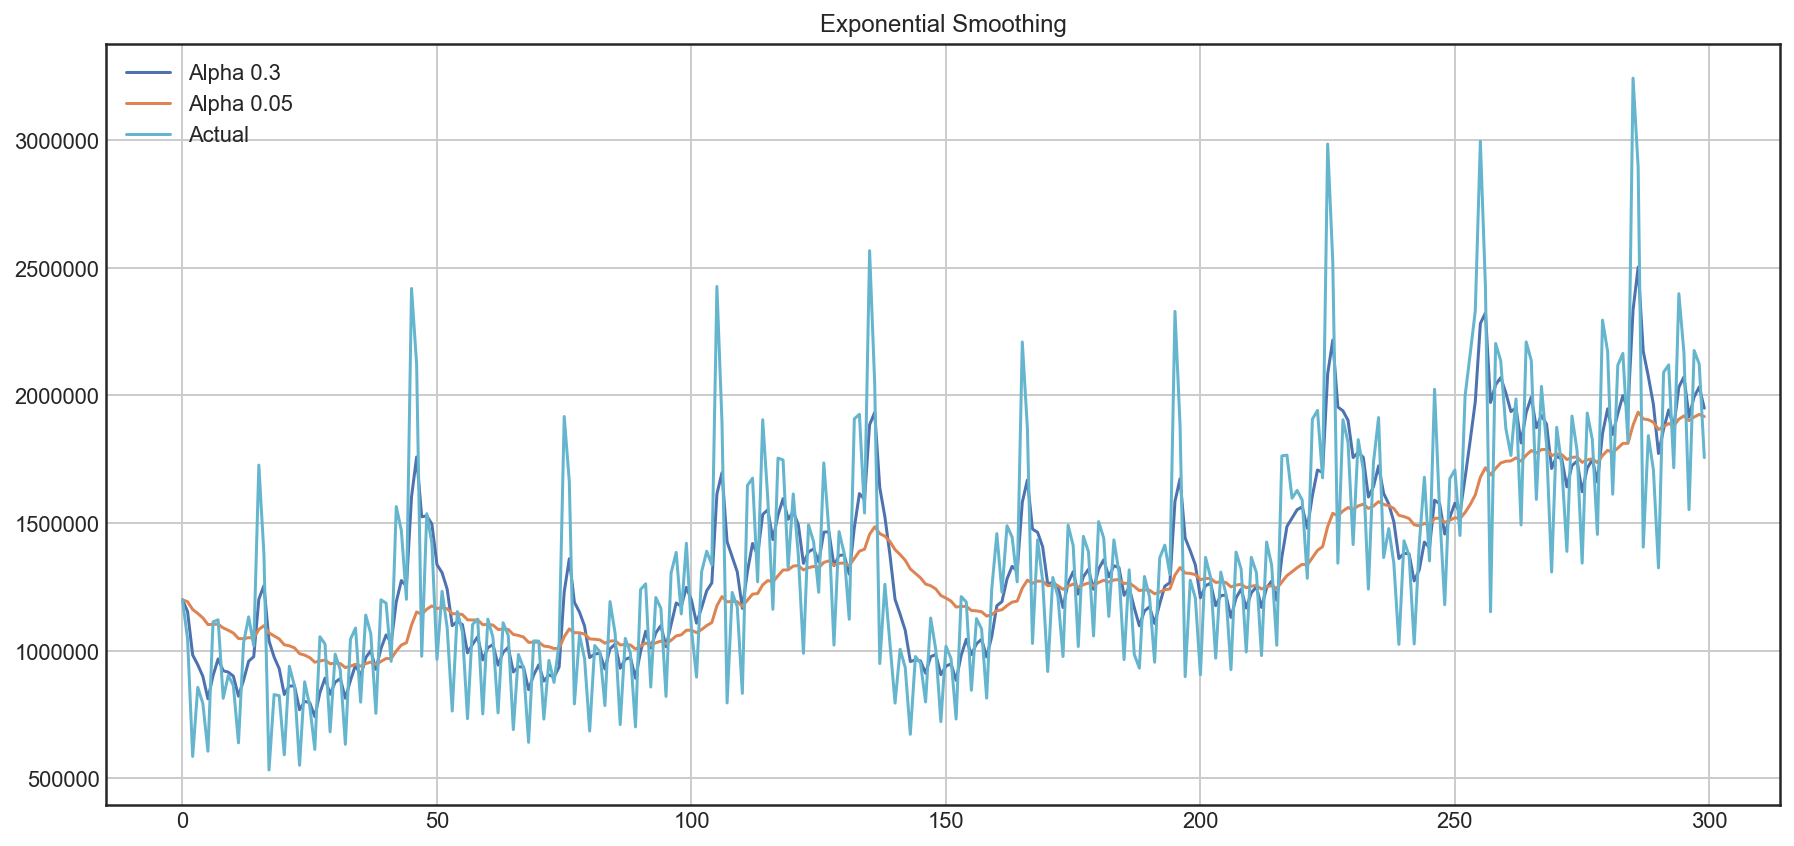

In [13]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

## Triple exponential smoothing a.k.a. Holt-Winters

We've looked at exponential smoothing and double exponential smoothing. This time, we're going into _triple_ exponential smoothing.

As you could have guessed, the idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done [here](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary $m$ future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

where $T$ is the length of the season, $d$ is the predicted deviation. Other parameters were taken from triple exponential smoothing. You can read more about the method and its applicability to anomaly detection in time series [here](http://fedcsis.org/proceedings/2012/pliks/118.pdf).

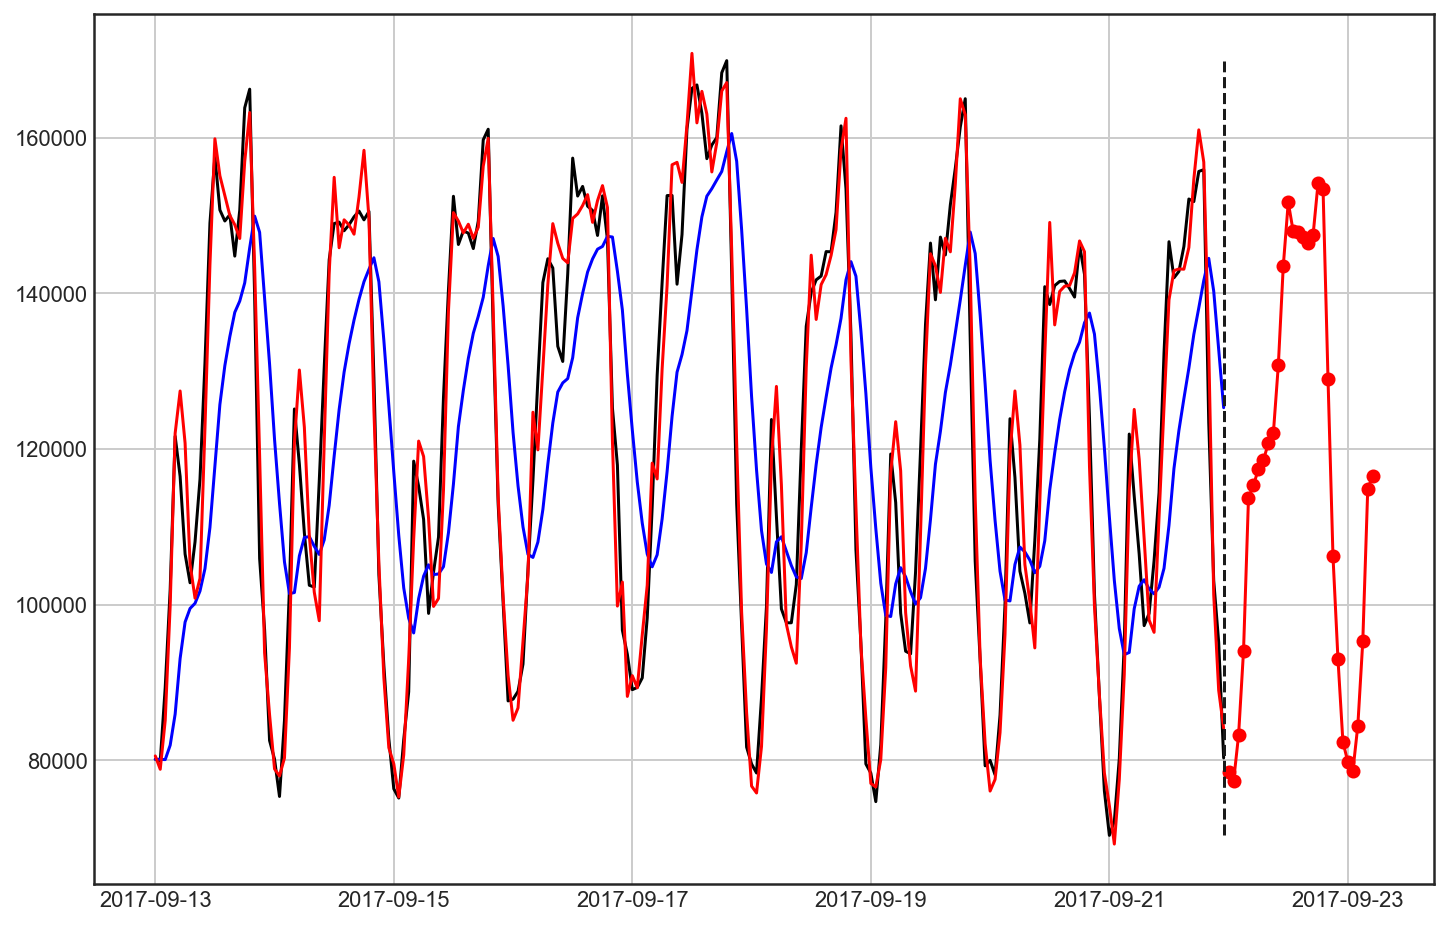

In [39]:
# looking for implemented solution in statsmodels
from matplotlib.dates import HourLocator
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

fit1 = SimpleExpSmoothing(ads.Ads).fit(smoothing_level=0.2, optimized=False)
fit2 = ExponentialSmoothing(ads.Ads, seasonal_periods=24,trend="add", seasonal="add",\
     damped_trend=True, use_boxcox=True).fit(smoothing_level=0.8, smoothing_trend=0.2)

fcast1 = fit1.forecast(30)
fcast2 = fit2.forecast(30)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(12, 8))
    plt.plot(ads.Ads, color="black")
    plt.plot(fit1.fittedvalues, color="blue")
    plt.plot(fit2.fittedvalues, color="red")
    (line2,) = plt.plot(fcast2, marker="o", color="red")
    plt.plot([ads.Ads.index[-1],ads.Ads.index[-1]], [ads.Ads.min(), ads.Ads.max()], 'k--')
    plt.axis('tight')
    plt.grid(True)


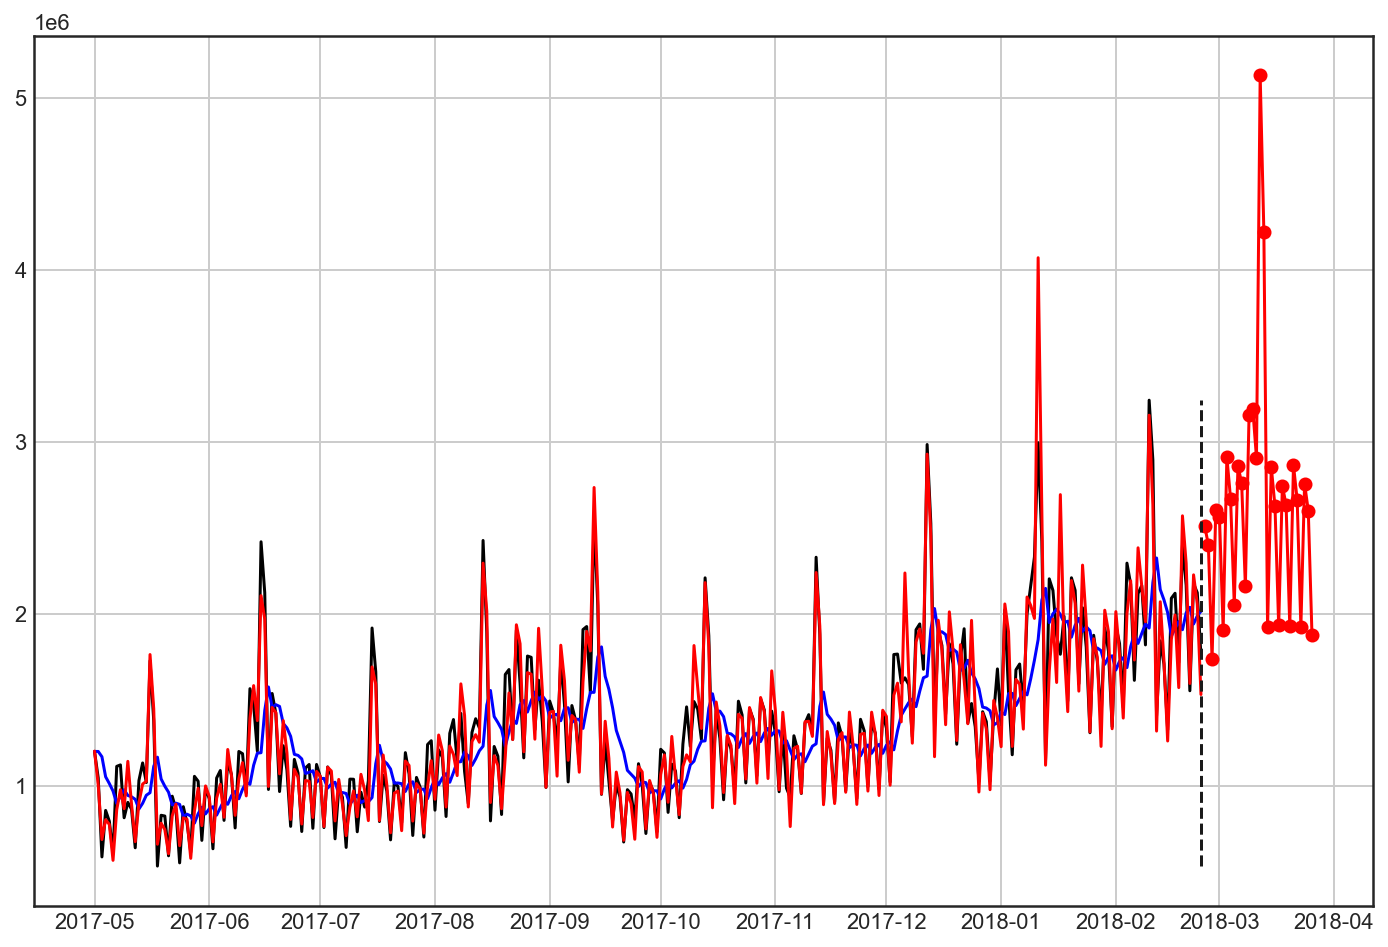

In [42]:
# looking for implemented solution in statsmodels
from matplotlib.dates import HourLocator
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

fit1 = SimpleExpSmoothing(currency.GEMS_GEMS_SPENT).fit(smoothing_level=0.2, optimized=False)
fit2 = ExponentialSmoothing(currency.GEMS_GEMS_SPENT, seasonal_periods=30,trend="add", seasonal="add",\
     damped_trend=True, use_boxcox=True).fit(smoothing_level=0.8, smoothing_trend=0.2)

fcast1 = fit1.forecast(30)
fcast2 = fit2.forecast(30)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(12, 8))
    plt.plot(currency.GEMS_GEMS_SPENT, color="black")
    plt.plot(fit1.fittedvalues, color="blue")
    plt.plot(fit2.fittedvalues, color="red")
    (line2,) = plt.plot(fcast2, marker="o", color="red")
    plt.plot([currency.GEMS_GEMS_SPENT.index[-1],currency.GEMS_GEMS_SPENT.index[-1]], [currency.GEMS_GEMS_SPENT.min(), currency.GEMS_GEMS_SPENT.max()], 'k--')
    plt.axis('tight')
    plt.grid(True)


# Econometric approach

## Getting rid of non-stationarity and building SARIMA

Let's build an ARIMA model.

Here is the code to render plots.

In [43]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

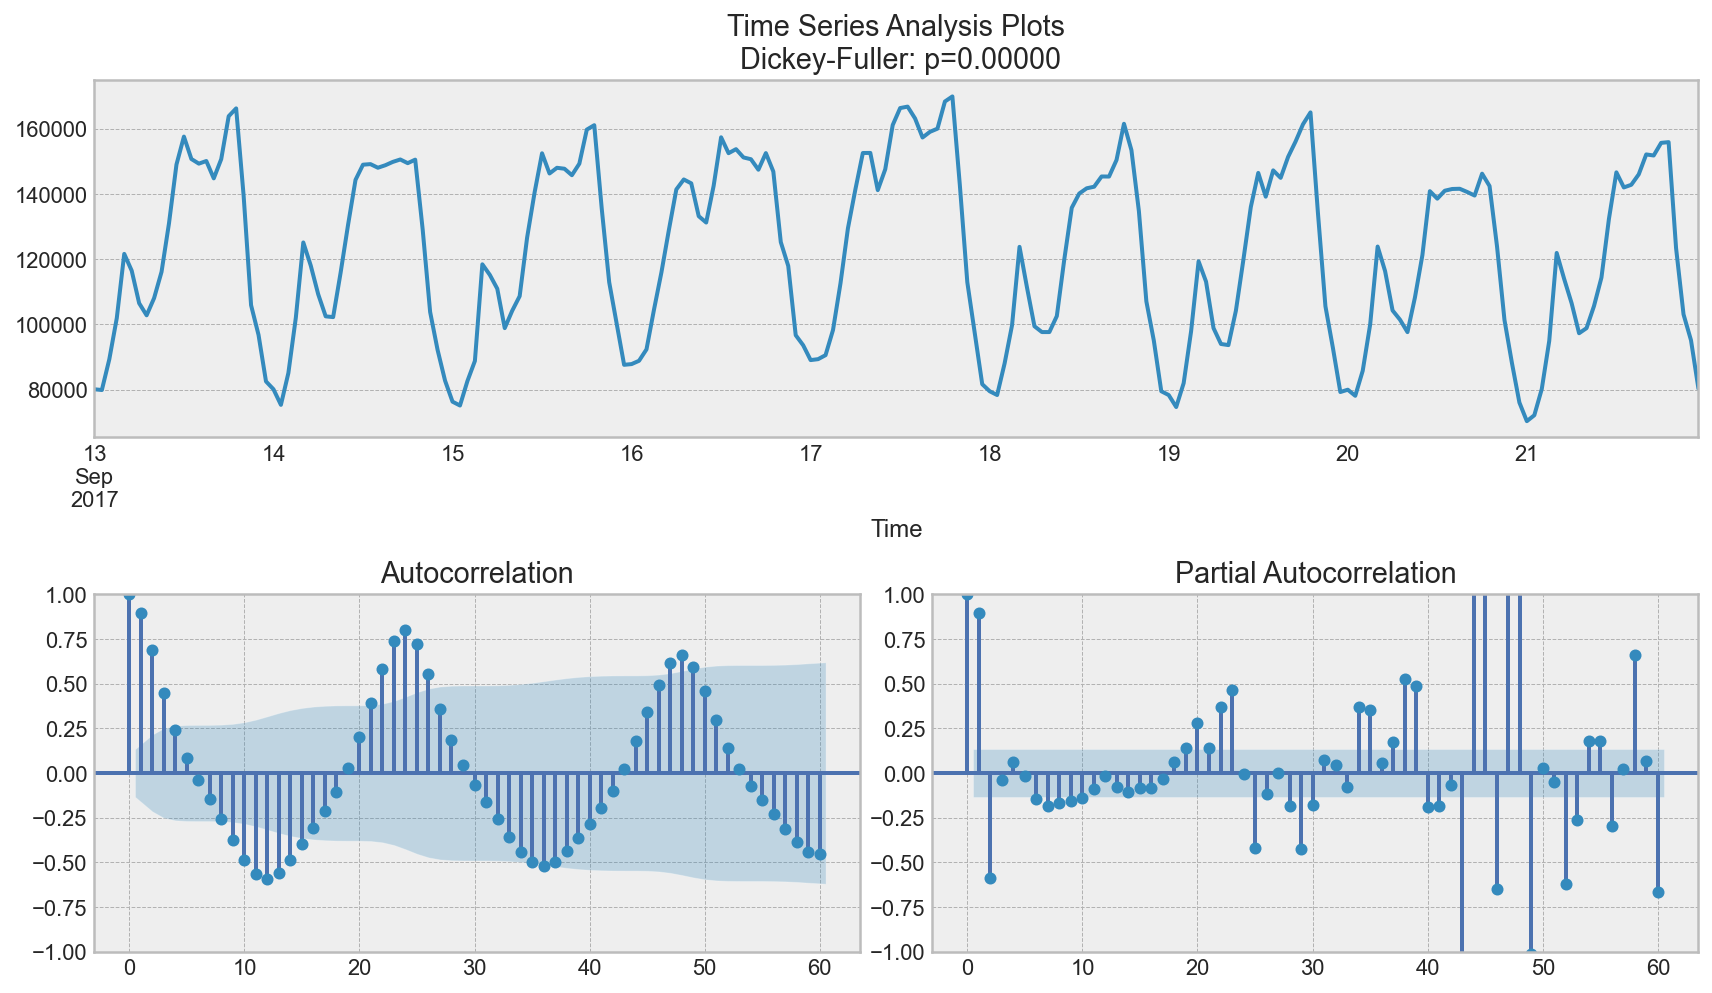

In [44]:
tsplot(ads.Ads, lags=60)

_this outlier on partial autocorrelation plot looks like a statsmodels bug, partial autocorrelation shall be <= 1 like any correlation._

Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. Actually, we can see this on the plot itself – we do not have a visible trend, so the mean is constant and the variance is pretty much stable. The only thing left is seasonality, which we have to deal with prior to modeling. To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

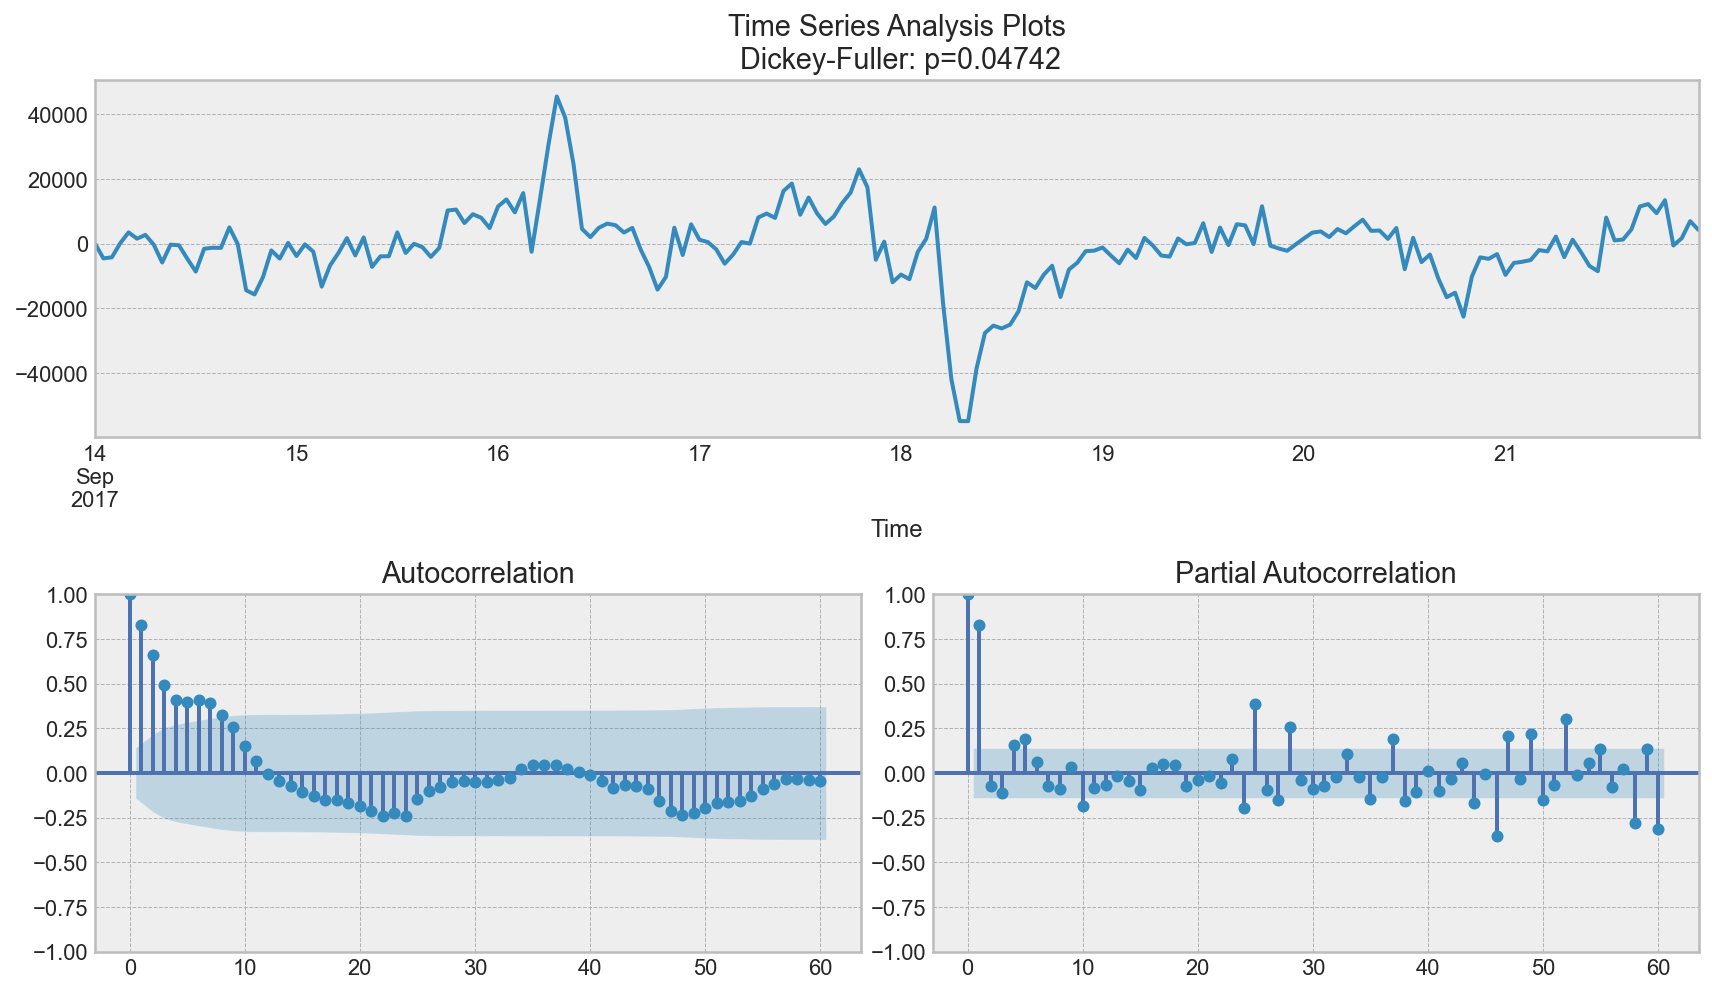

In [45]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

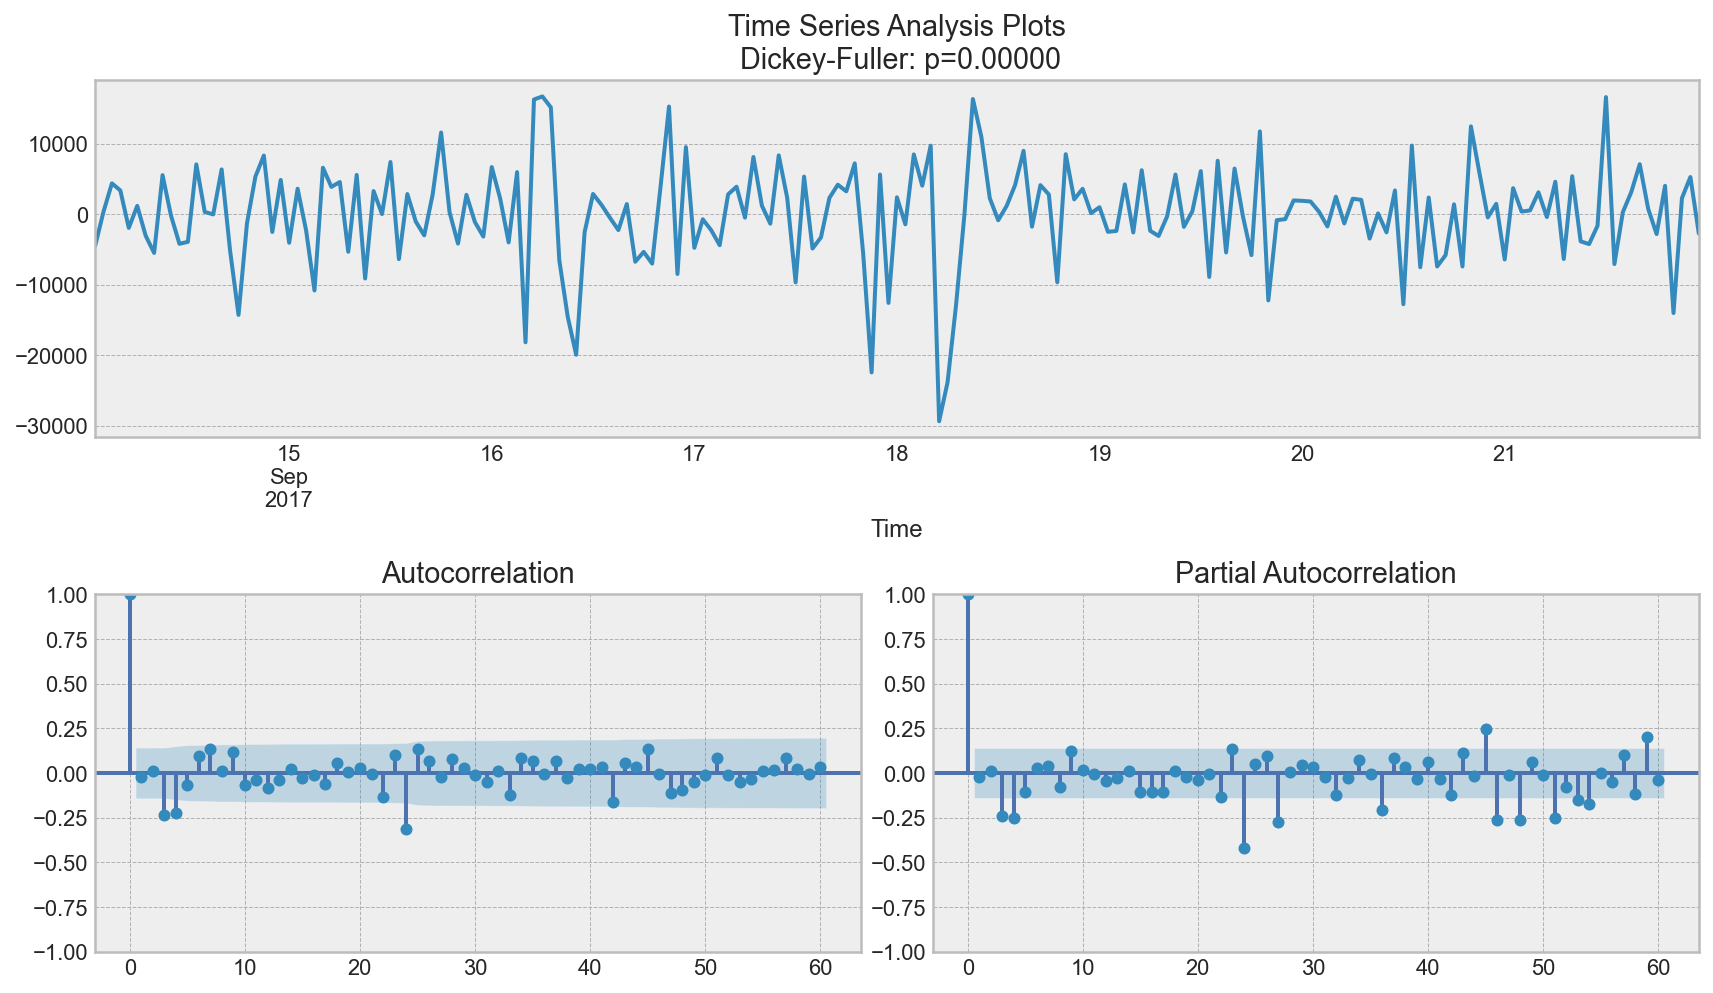

In [46]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Perfect! Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

## ARIMA-family Crash-Course

We will explain this model by building up letter by letter. $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as $p$. To determine the initial $p$, you need to look at the PACF plot and find the biggest significant lag after which **most** other lags become insignificant.
- $MA(q)$ - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as $q$. The initial value can be found on the ACF plot with the same logic as before. 

Let's combine our first 4 letters:

$AR(p) + MA(q) = ARMA(p, q)$

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

- $I(d)$ - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences. 

Adding this letter to the four gives us the $ARIMA$ model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

- $S(s)$ - this is responsible for seasonality and equals the season period length of the series

With this, we have three parameters: $(P, D, Q)$

- $P$ - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial $P$ should be 2.

- $Q$ - similar logic using the ACF plot instead.

- $D$ - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

Now that we know how to set the initial parameters, let's have a look at the final plot once again and set the parameters:

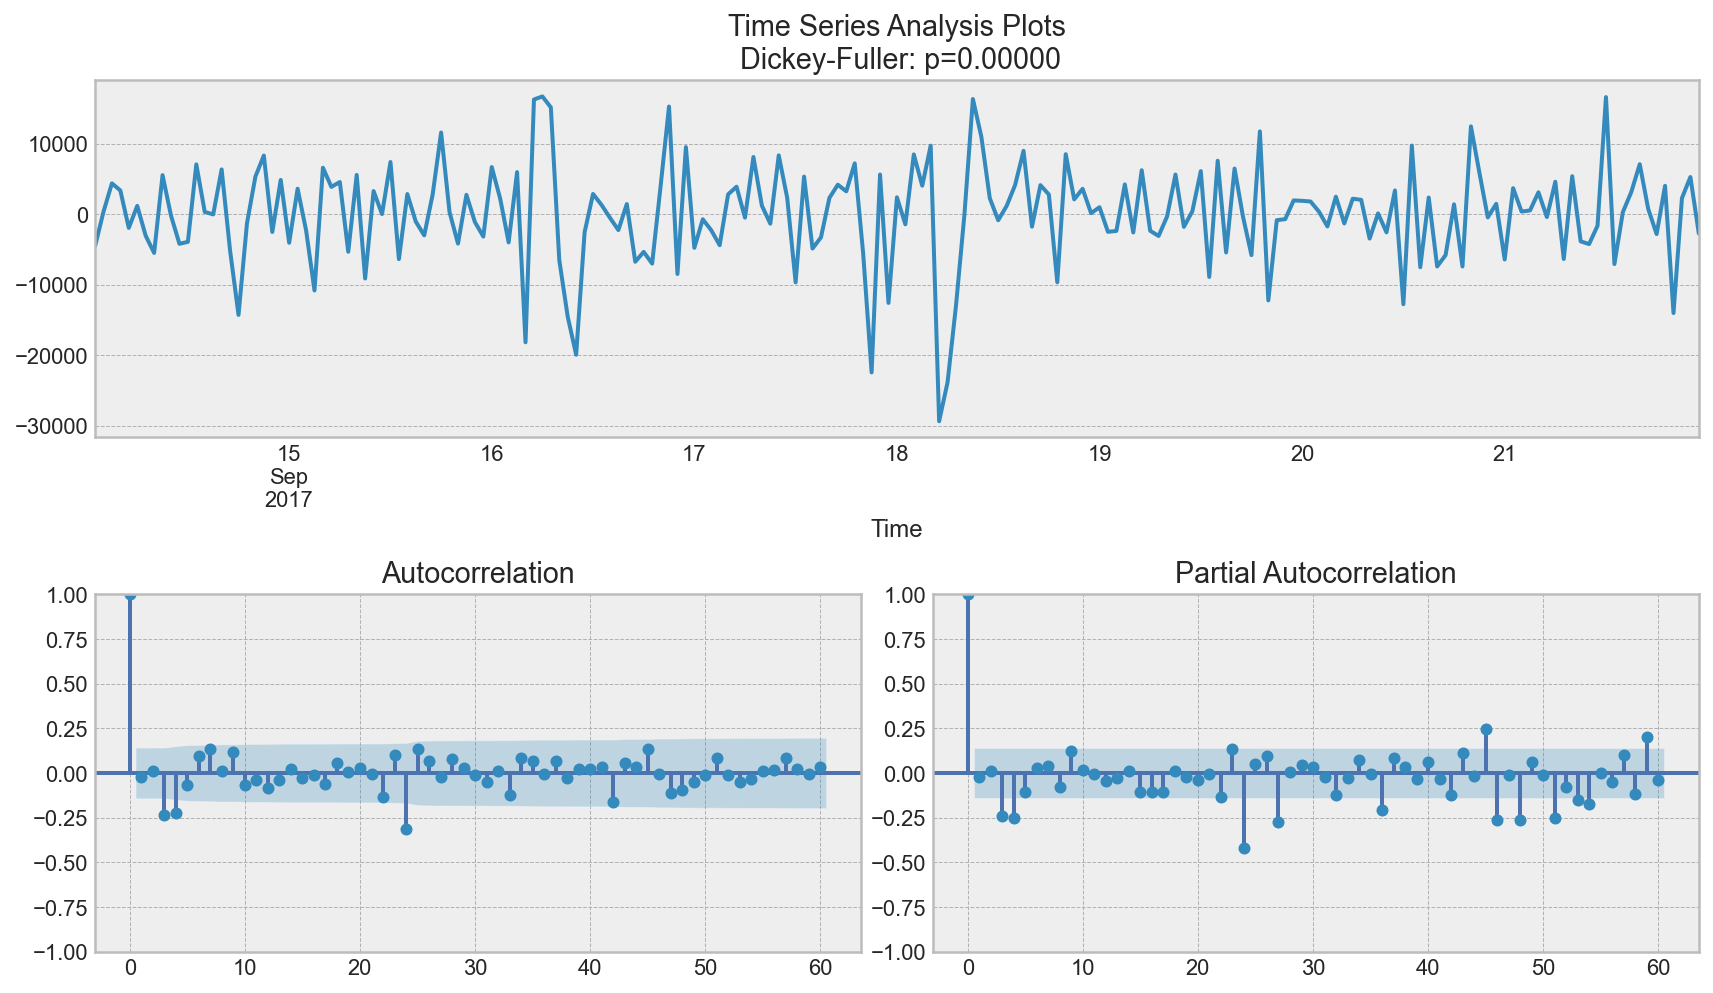

In [47]:
tsplot(ads_diff[24+1:], lags=60)

## First SARIMA model

Let's have a try!

In [ ]:
# parameter are described just below

# the following parameters are good (output of the optimization process described below)
s = 24 # season length is still 24
d,D = 1,1 # differentiation (local/season)
p,q,P,Q = (2, 3, 1, 1) # nb values (Reg), nb values (MA), nb values (Season Reg), nb values (Season MA),

model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

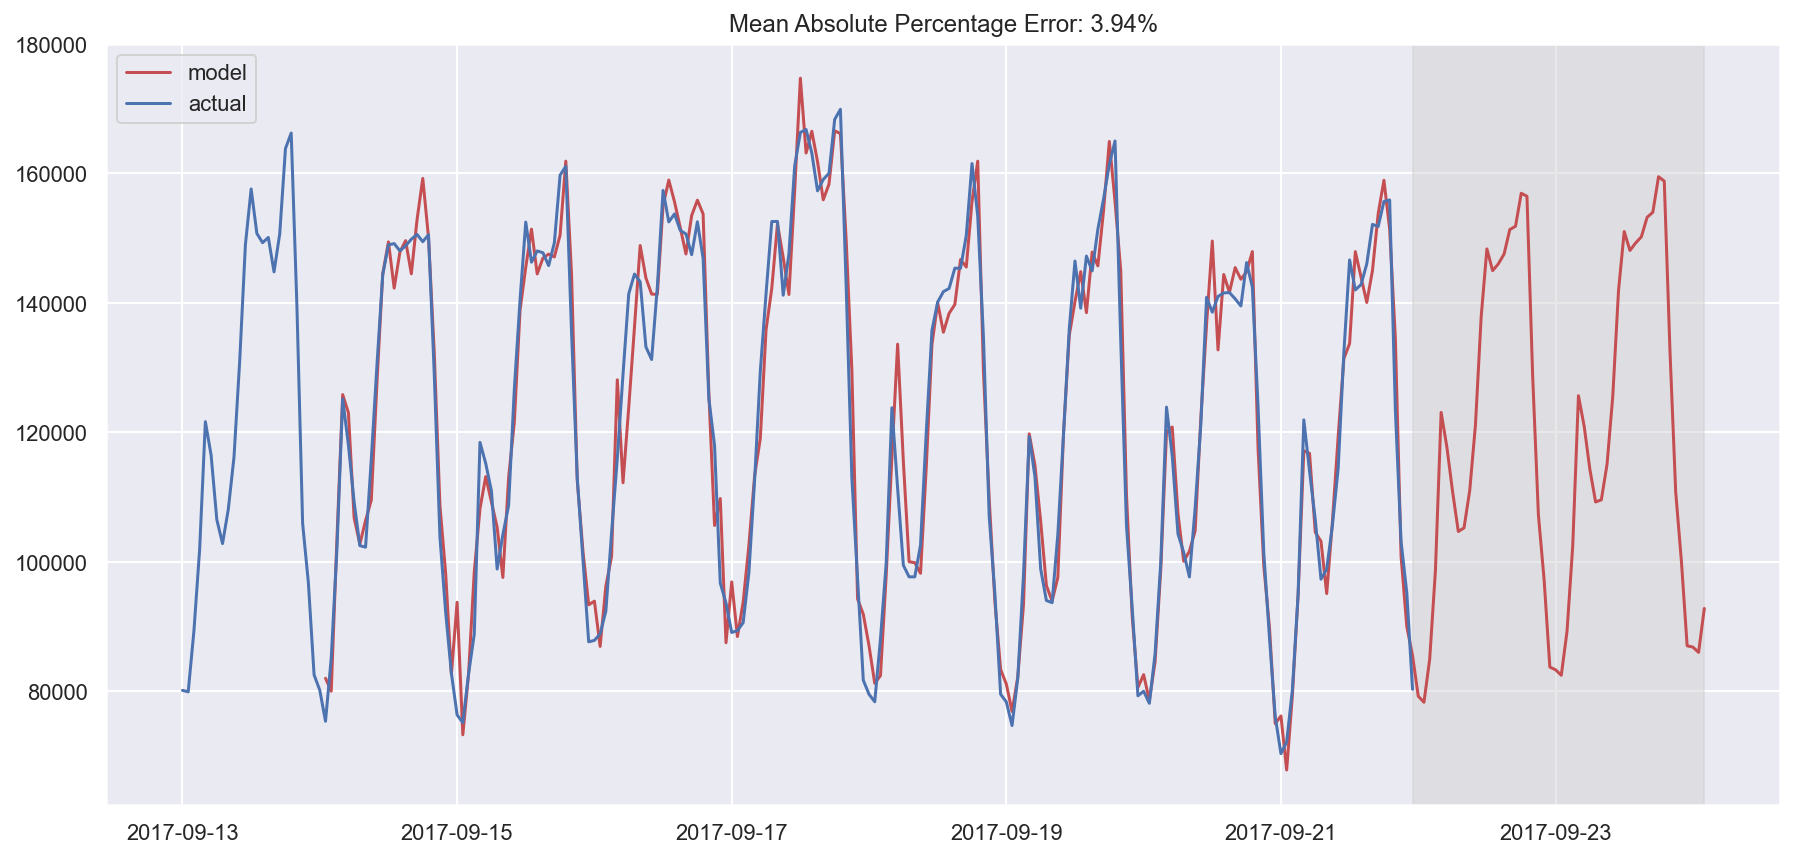

In [ ]:
plotSARIMA(ads, model, 50)

## Parameter optimization

Very useful... But takes time.

- $p$ is most probably 4 since it is the last significant lag on the PACF, after which, most others are not significant. 
- $d$ equals 1 because we had first differences
- $q$ should be somewhere around 4 as well as seen on the ACF
- $P$ might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
- $D$ again equals 1 because we performed seasonal differentiation
- $Q$ is probably 1. The 24-th lag on ACF is significant while the 48-th is not.

Let's test various models and see which one is better.

In [48]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [49]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [50]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 43min 5s, sys: 12min 48s, total: 55min 53s
Wall time: 15h 23min 12s


In [30]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


In [54]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]


best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

2 3 1 1
                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Sun, 06 Nov 2022   AIC                           3888.642
Time:                                      09:52:05   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2      

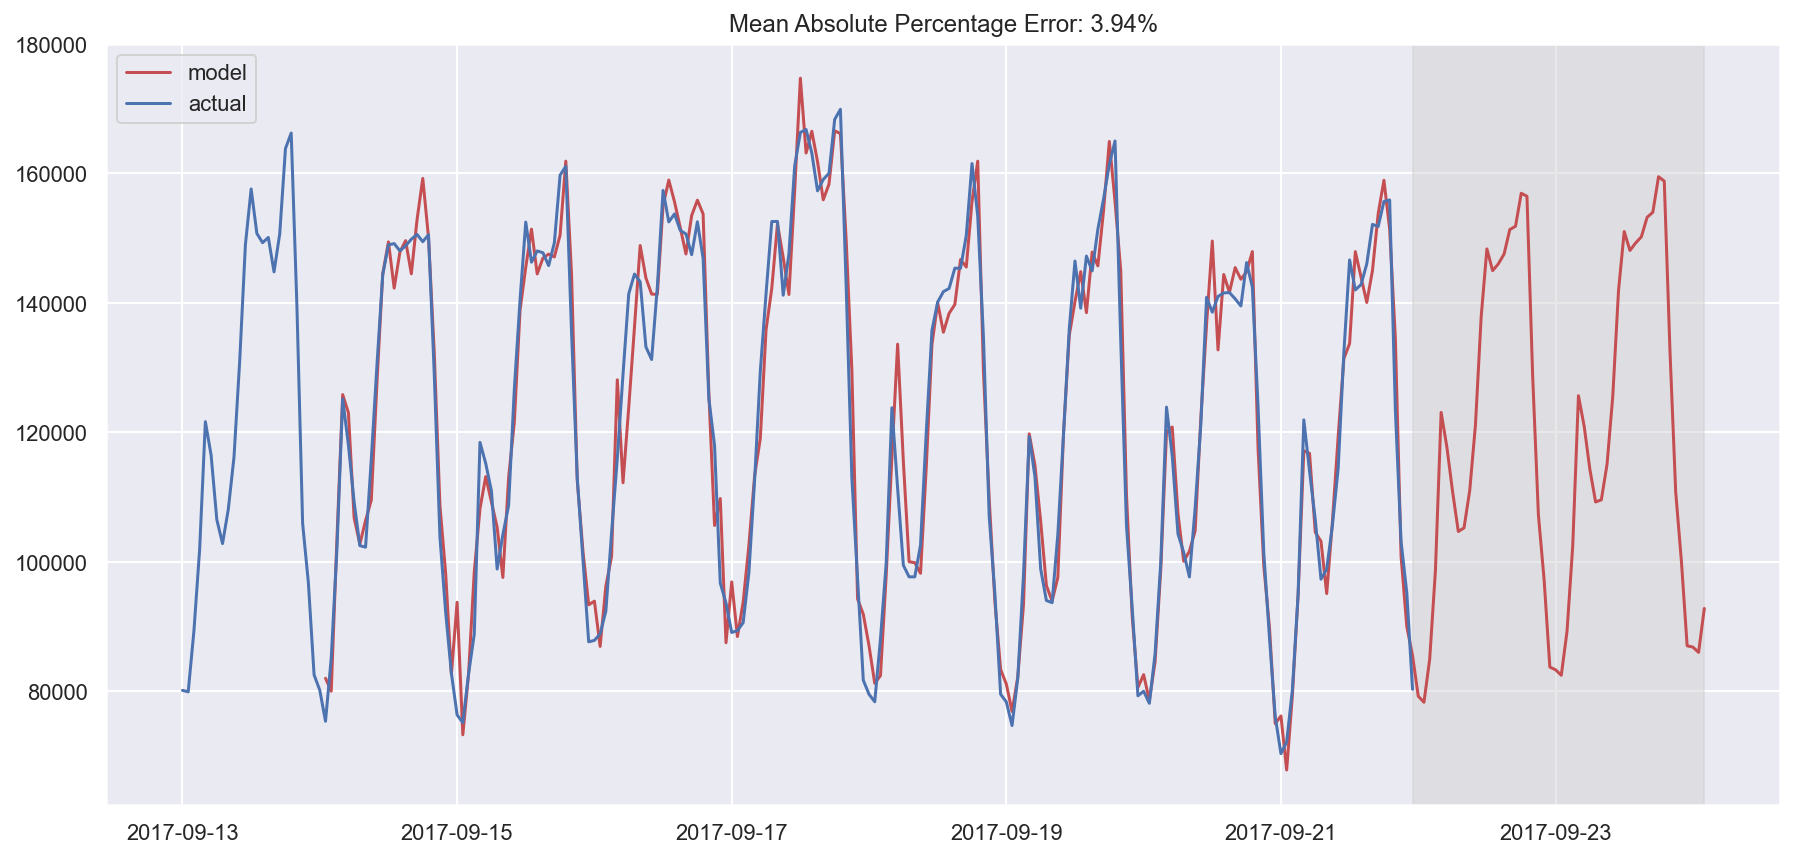

In [53]:
plotSARIMA(ads, best_model, 50)

In the end, we got very adequate predictions. Our model was wrong by 4.01% on average, which is very, very good. However, the overall costs of preparing data, making the series stationary, and selecting parameters might not be worth this accuracy.